In [1]:
!pip3 install -U matplotlib -q
!pip3 install -U torch torchvision -q --index-url https://download.pytorch.org/whl/cu118

Loading saved weights/biases


100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:07<00:00, 24199664.94it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
Epoch: 1 train_loss: 0.31193
Epoch: 2 train_loss: 0.29890
Epoch: 3 train_loss: 0.29407
Epoch: 4 train_loss: 0.28878
Epoch: 5 train_loss: 0.28597
Epoch: 6 train_loss: 0.27839
Epoch: 7 train_loss: 0.27466
Epoch: 8 train_loss: 0.26654
Epoch: 9 train_loss: 0.26228
Epoch: 10 train_loss: 0.25646
Elapsed time: 0:08:17.079325


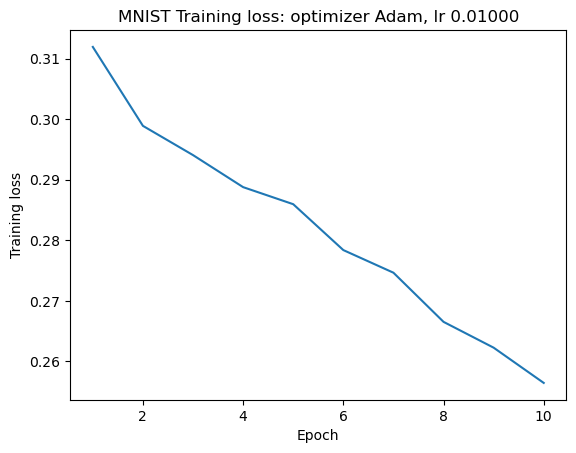

Test loss 0.01333, test accuracy: 73.92516


In [1]:
import os
import time
from datetime import timedelta
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

class CIFARClassifier(nn.Module):
    def __init__(self):
        super(CIFARClassifier, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.block2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12544, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.block1(x)
        return self.block2(x)

SESSION_EPOCHS = 10
BATCH_SIZE = 64
INPUT_DIM = 32*32*3
LEARNING_RATE = 1e-2
BETAS = (0.9, 0.999)
EPS = 1e-8
STATE_DICT = '11_CIFAR10_PyTorch.pt'

classifier = CIFARClassifier()
optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE, betas=BETAS, eps=EPS, weight_decay=0, amsgrad=False)

if os.path.exists("./{}".format(STATE_DICT)):
    print("Loading saved weights/biases")
    classifier.load_state_dict(torch.load(STATE_DICT))

train_dataset = CIFAR10(
                    ".", 
                    download=True, 
                    train=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    ]))
test_dataset = CIFAR10(
                    ".", 
                    download=True, 
                    train=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    ]))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

def train(
    classifier=classifier,
    optimizer=optimizer,
    epochs=SESSION_EPOCHS,
    loss_fn=nn.CrossEntropyLoss()):

    classifier.train()
    loss_lt = []
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        for minibatch in train_loader:
            data, target = minibatch
            out = classifier(data)
            computed_loss = loss_fn(out, target)
            computed_loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            running_loss += computed_loss.item()

        loss_lt.append(running_loss/len(train_loader))
        print("Epoch: %d train_loss: %0.5f" % (epoch+1, running_loss/len(train_loader)))
            
    end_time = time.time()
    print("Elapsed time: %s" % timedelta(seconds=end_time-start_time))

    plt.plot([i for i in range(1, epochs+1)], loss_lt)
    plt.xlabel("Epoch")
    plt.ylabel("Training loss")
    plt.title("MNIST Training loss: optimizer %s, lr %0.5f" % ("Adam", LEARNING_RATE))
    plt.show()

    torch.save(classifier.state_dict(), STATE_DICT)

def test(
    classifier=classifier,
    loss_fn=nn.CrossEntropyLoss()):

    classifier.eval()
    accuracy = 0.0
    computed_loss = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            out = classifier(data)
            _, preds = out.max(dim=1)

            # Get loss and accuracy
            computed_loss += loss_fn(out, target)
            accuracy += torch.sum(preds==target)

    print("Test loss %0.5f, test accuracy: %0.5f" % (
        computed_loss.item() / (len(test_loader)*BATCH_SIZE),
        accuracy * 100.0 / (len(test_loader)*BATCH_SIZE),
    ))

train()
test()